#Random Agent
This is a agent that plays numEpisodes number of games by choosing random actions until done. Game with best score is kept and rendered.

#Mount Google Drive

In [0]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
TensorFlow 2.x selected.
Note: using Google CoLab


#Install Retro & Imports

In [0]:
!pip3 install gym-retro # install OpenAI Gym-Retro

     |████████████████████████████████| 162.0MB 29kB/s 


In [0]:
import gym
import retro
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2
import os
from datetime import datetime, timedelta
from time import time

#Install Roms

In [0]:
# install roms
romPath = '/content/drive/My Drive/Colab Notebooks/Roms/'
for rom in os.listdir(romPath):
  retro.data.merge(romPath + rom, quiet=False)

Importing SpaceInvaders-Nes
Imported 1 games
Importing Joust-Nes
Imported 1 games
Importing SuperMarioBros-Nes
Imported 1 games
Importing MsPacMan-Nes
Imported 1 games


#Environment Wrappers

In [0]:
# Discretize continuous action space
class Discretizer(gym.ActionWrapper):
  def __init__(self, env, combos):
    super().__init__(env)
    assert isinstance(env.action_space, gym.spaces.MultiBinary)
    buttons = env.unwrapped.buttons
    self._decode_discrete_action = []
    for combo in combos:
      arr = np.array([False] * env.action_space.n)
      for button in combo:
        arr[buttons.index(button)] = True
      self._decode_discrete_action.append(arr)

    self.action_space = gym.spaces.Discrete(len(self._decode_discrete_action))

  def action(self, act):
    return self._decode_discrete_action[act].copy()

# Limit the episode length
class TimeLimit(gym.Wrapper):
  def __init__(self, env, max_episode_steps=None):
    super().__init__(env)
    self._max_episode_steps = max_episode_steps
    self._elapsed_steps = 0

  def step(self, action):
    obs, reward, done, info = self.env.step(action)
    self._elapsed_steps += 1
    if self._elapsed_steps >= self._max_episode_steps:
      done = True
      info['TimeLimit.truncated'] = True
    return obs, reward, done, info

  def reset(self, **kwargs):
    self._elapsed_steps = 0
    return self.env.reset(**kwargs)

# Skip frames
class SkipFrames(gym.Wrapper):
  def __init__(self, env, n = 4):
    gym.Wrapper.__init__(self, env)
    self.n = n

  def step(self, action):
    done = False
    totalReward = 0.0
    for _ in range(self.n):
      obs, reward, done, info = self.env.step(action)
      totalReward += reward
      if done:
        break
    return obs, totalReward, done, info

# Convert observation to greyscale
class Rgb2Gray(gym.ObservationWrapper):
  def __init__(self, env):
    gym.ObservationWrapper.__init__(self, env)
    (oldh, oldw, _oldc) = env.observation_space.shape
    self.observation_space = gym.spaces.Box(low = 0, high = 255,
                                            shape = (oldh, oldw, 1),
                                            dtype = np.uint8)
    
  def observation(self, frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    return frame[:,:,None]

# Downsample the observation
class Downsample(gym.ObservationWrapper):
    def __init__(self, env, ratio):
        gym.ObservationWrapper.__init__(self, env)
        (oldh, oldw, oldc) = env.observation_space.shape
        newshape = (oldh//ratio, oldw//ratio, oldc)
        self.observation_space = gym.spaces.Box(low = 0, high = 255,
                                                shape = newshape,
                                                dtype = np.uint8)

    def observation(self, frame):
        height, width, _ = self.observation_space.shape
        frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
        if frame.ndim == 2:
            frame = frame[:, :, None]
        return frame

from collections import deque
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        gym.Wrapper.__init__(self, env)
        (oldh, oldw, _oldc) = env.observation_space.shape
        newStackShape = (oldh, oldw, k)
        self.observation_space = gym.spaces.Box(low = 0, high = 255,
                                                shape = newStackShape,
                                                dtype = np.uint8)
        self.k = k
        self.frames = deque([], maxlen = k)

    def reset(self):
        obs = self.env.reset()
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_obs()

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_obs(), reward, done, info

    def _get_obs(self):
        assert len(self.frames) == self.k
        return np.concatenate(self.frames, axis = 2)

# combine the wrappers
def make_env(game, state, scenario, record, obs_type, combos, timeLimit, downsampleRatio):
  env = retro.make(game=game, state=state, scenario=scenario, record=record, obs_type=obs_type)
  env = Discretizer(env, combos=combos)
  env = TimeLimit(env, timeLimit)
  env = SkipFrames(env)
  env = Rgb2Gray(env)
  env = Downsample(env, downsampleRatio)
  env = FrameStack(env, 4)
  return env

#Utility functions

In [0]:
# Render avi or gif
def renderFrames(frame_array, savePath, fileName, fps, otype='AVI'):
  print('Creating replay ...', end=' ')
  if otype == 'AVI':
    fileName += '.avi'
    height, width, layers = frame_array[0].shape
    if layers == 1:
      layers = 0
    size = (width, height)
    out = cv2.VideoWriter(savePath + fileName, cv2.VideoWriter_fourcc(*'DIVX'), fps, size, layers)
    for i in range(len(frame_array)):
      out.write(frame_array[i])
    out.release()
    print('Done. Saved to {}'.format(savePath + fileName))
  elif otype == 'GIF':
    fileName += '.gif'
    imageio.mimwrite(savePath + fileName, replay, fps=fps)
    print('Done. Saved to {}'.format(savePath + fileName))
  else:
    print('Error: Invalid type, must be GIF or AVI.')

# Get current date/time foramtted as string
def Now():
  # subtract 6 hours to get correct tz
  now = datetime.now() - timedelta(hours=6)
  return now.strftime('%m_%d_%Y_%H%M%S')

# save the log to file
def saveLog(savePath, fileName, log):
  print('Saving log ...', end=' ')
  fileName += '.log'
  f = open(savePath + fileName, 'w')
  for line in log:
    f.write(line + '\n')
  f.write(Now())
  f.close()
  print('Done. Saved to {}'.format(savePath + fileName))

#Agent

In [0]:
class Results:
  def __init__(self):
    self.episode = None
    self.score = -np.inf
    self.actions = []
    self.frames = []
    self.obsFrames = []
    self.log = []

class Agent:
  def __init__(self, env):
    self._env = env
    self.results = Results() # store the results of the best eipsode

  def _select_action(self):
    action = self._env.action_space.sample() # sample a random action
    return action

  def play(self, numEpisodes = 1, verbose = 2):
    sTime = time()
    for i in range(numEpisodes):
      obs = self._env.reset()
      epsiodeScore = 0
      actions = []
      frames = []
      obsFrames = []
      while True:
        action = self._select_action()
        obs, reward, done, info = self._env.step(action)
        epsiodeScore += reward
        frames.append(self._env.render(mode='rgb_array'))
        obsFrames.append(obs)
        actions.append(action)
        if done:
          logStr = 'Episode {:d}: actions={:d}, score={}'.format(
              i+1, len(actions), epsiodeScore)
          self.results.log.append(logStr)
          if verbose > 1:
            print(logStr)
          break
      if epsiodeScore > self.results.score:
        self.results.score = epsiodeScore
        self.results.episode = i+1
        self.results.actions = actions
        self.results.frames = frames
        self.results.obsFrames = obsFrames
    eTime = round(time() - sTime, 4)
    logStr1 = '{} episodes ran and took {} seconds'.format(
        numEpisodes, eTime)
    logStr2 = 'Episode {:d} had the best score of {}.'.format(
        self.results.episode, self.results.score)
    self.results.log.append(logStr1)
    self.results.log.append(logStr2)
    if verbose > 0:
      if verbose > 1:
        print('-'*80)
      print(logStr1); print(logStr2);

#Setup

In [0]:
class Args:
  game = ['SpaceInvaders-Nes', 'Joust-Nes', 'SuperMarioBros-Nes', 'MsPacMan-Nes']
  combos = [ [['LEFT'], ['RIGHT'], ['A'], ['LEFT', 'A'], ['RIGHT', 'A']],
             [['LEFT'], ['RIGHT'], ['UP'], ['DOWN']] ]
  state = retro.State.DEFAULT
  scenario = 'scenario'
  record = False
  obs_type = retro.Observations.IMAGE
  savePath = '/content/drive/My Drive/Colab Notebooks/'

args = Args()

#Train

In [0]:
# you don't acually need this but usefull for debugging if env() was 
# not closed probably because bug
try: 
  if env:
    env.close()
except NameError:
  pass

# 0: Space Invaders (NES) 1: Joust (NES) 2: Super Mario Bros (SNES) 3: Ms. Pacman
# 0: [LT, RT, A] 1: [LT, RT, UP, DN]
gameIndex, comboIndex, numEpisodes = 0, 0, 3

env = make_env(args.game[gameIndex], args.state, args.scenario, args.record,
               args.obs_type, args.combos[comboIndex], 5000, 2)

agent = Agent(env)
agent.play(numEpisodes=numEpisodes)

env.close()

fileName = 'Random_' + Args.game[gameIndex] + '_E{}_{}'.format(
    agent.results.episode, Now())
renderFrames(agent.results.frames, args.savePath, fileName, 60, otype='AVI')
fileName = 'Random_' + Args.game[gameIndex]
saveLog(args.savePath, fileName, agent.results.log)

Episode 1: actions=962, score=180.0
Episode 2: actions=745, score=150.0
Episode 3: actions=954, score=90.0
--------------------------------------------------------------------------------
3 episodes ran and took 7.0248 seconds
Episode 1 had the best score of 180.0.
Creating replay ... Done. Saved to /content/drive/My Drive/Colab Notebooks/Random_SpaceInvaders-Nes_E1_03_10_2020_191537.avi
Saving log ... Done. Saved to /content/drive/My Drive/Colab Notebooks/Random_SpaceInvaders-Nes.log


#Extra
Examples on how to print out buttons, supported games, sample action, action and observation space.


In [0]:
print('Buttons:', env.buttons) # list buttons
print('Games:', retro.data.list_games()) # list supported games
print('Sample Action:', env.action_space.sample())
print('Action Space:', env.action_space)
print('Observation Space:', env.observation_space)

Buttons: ['B', None, 'SELECT', 'START', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'A']
Games: ['1942-Nes', '1943-Nes', '3NinjasKickBack-Genesis', '8Eyes-Nes', 'AaahhRealMonsters-Genesis', 'AbadoxTheDeadlyInnerWar-Nes', 'AcceleBrid-Snes', 'ActRaiser2-Snes', 'ActionPachio-Snes', 'AddamsFamily-GameBoy', 'AddamsFamily-Genesis', 'AddamsFamily-Nes', 'AddamsFamily-Sms', 'AddamsFamily-Snes', 'AddamsFamilyPugsleysScavengerHunt-Nes', 'AddamsFamilyPugsleysScavengerHunt-Snes', 'AdvancedBusterhawkGleylancer-Genesis', 'Adventure-Atari2600', 'AdventureIsland-GameBoy', 'AdventureIsland3-Nes', 'AdventureIslandII-Nes', 'AdventuresOfBatmanAndRobin-Genesis', 'AdventuresOfBayouBilly-Nes', 'AdventuresOfDinoRiki-Nes', 'AdventuresOfDrFranken-Snes', 'AdventuresOfKidKleets-Snes', 'AdventuresOfMightyMax-Genesis', 'AdventuresOfMightyMax-Snes', 'AdventuresOfRockyAndBullwinkleAndFriends-Genesis', 'AdventuresOfRockyAndBullwinkleAndFriends-Nes', 'AdventuresOfRockyAndBullwinkleAndFriends-Snes', 'AdventuresOfStarSaver-GameBoy', '

Comparing the observation to the render. Will be different or same depending on wrappers used. Doesn't actually matter as we are not passing observation to anything since agent just does random actions.

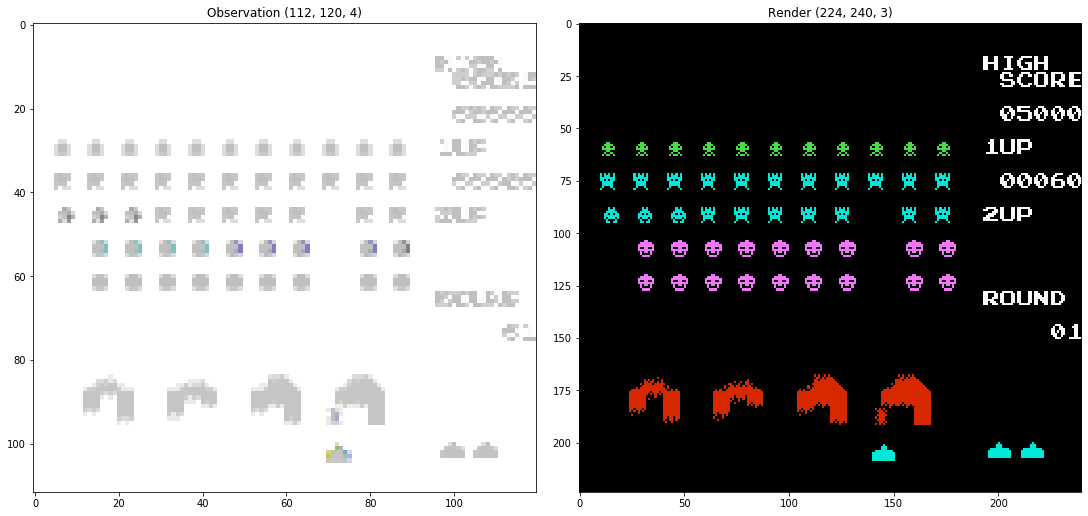

In [0]:
# compare obs and render of random frames
fig, axes = plt.subplots(1,2,figsize=(15, 15), constrained_layout=True)
index = np.random.choice(range(len(agent.results.frames)))
img1 = agent.results.obsFrames[index].squeeze()
img2 = agent.results.frames[index].squeeze()
axes[0].imshow(img1, cmap='gray')
axes[1].imshow(img2)
axes[0].set_title('Observation {}'.format(img1.shape))
axes[1].set_title('Render {}'.format(img2.shape))
fig.show()

If stack frames wrapper is used for the observation this unpacks the four frames so you can see them all.

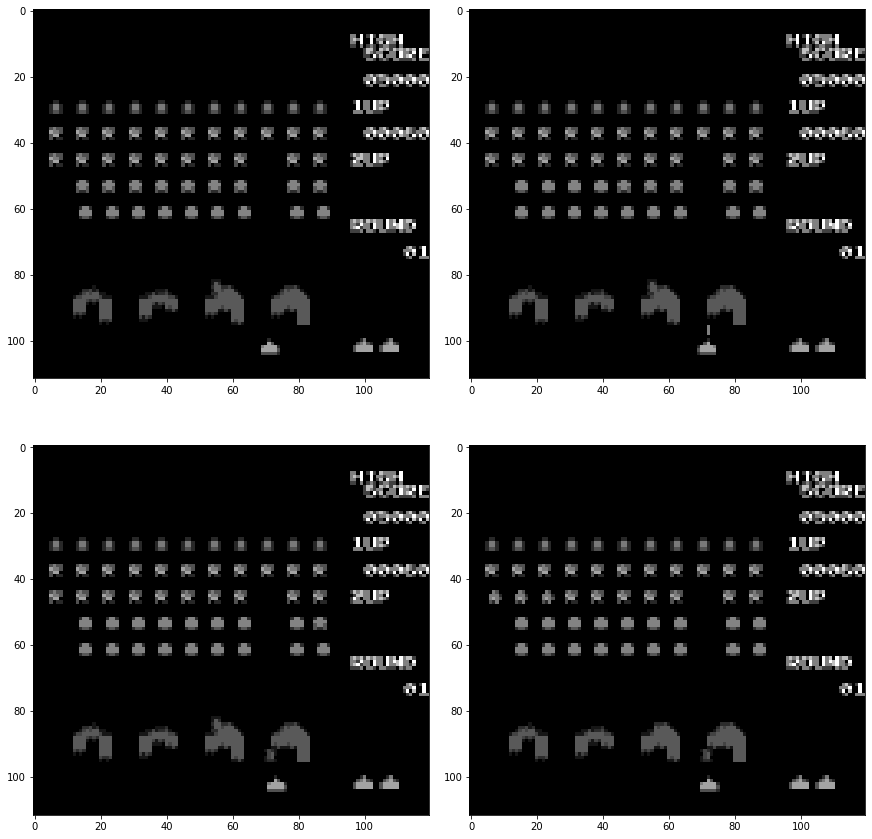

In [0]:
fig, axes = plt.subplots(2,2,figsize=(12, 12), constrained_layout=True)
axes = axes.flatten()
for i in range(4):
  axes[i].imshow(agent.results.obsFrames[index][:, :, i], cmap='gray')